<a href="https://colab.research.google.com/github/ethanwilkinson1/COVID-Net/blob/main/pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
from glob import glob
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Activation
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.layers.experimental.preprocessing import Rescaling, Resizing
from tensorflow.keras.layers.experimental.preprocessing import RandomZoom, RandomFlip
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam, RMSprop, Adadelta, Nadam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import BinaryAccuracy, AUC, Precision, Recall, TruePositives, TrueNegatives, FalsePositives, FalseNegatives
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras import applications
from sklearn.metrics import confusion_matrix
import itertools
import datetime
import matplotlib.pyplot as plt
import random
import numpy as np
import os

# Preparing the data

This code cell adds a user's google drive to the runtime's file browsing menu, which can be accessed from the left side navigation bar.

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Next, unzip a compressed dataset file to a temporary folder inside the instance. It is important to store the data locally in the runtime instance for use as accessing the google drive repeatedly would severly bottleneck processing.

In [ ]:
!unzip '/content/drive/MyDrive/datasets/COVID_dataset.zip' -d 'data/'

Define and list the contents of the base folder and its subfolders to check that the dataset's directory structure is as expexted.

In [ ]:
base_folder = 'data/COVID_dataset'
print(glob(base_folder + '/*'))

train_dir = 'data/COVID_dataset/train'
print(glob(train_dir + '/*'))

validation_dir = 'data/COVID_dataset/validation'
print(glob(validation_dir + '/*'))

test_dir = 'data/COVID_dataset/test'
print(glob(test_dir + '/*'))

['data/COVID_dataset/validation', 'data/COVID_dataset/test', 'data/COVID_dataset/COVID.metadata.xlsx', 'data/COVID_dataset/train', 'data/COVID_dataset/Normal.metadata.xlsx']
['data/COVID_dataset/train/COVID', 'data/COVID_dataset/train/Normal']
['data/COVID_dataset/validation/COVID', 'data/COVID_dataset/validation/Normal']
['data/COVID_dataset/test/COVID', 'data/COVID_dataset/test/Normal']


Further define the class folders of each subfolder and print the number of images in each class folder to the screen. This is to check that the class folders have the same proportional representation in each subfolder.

In [ ]:
# Count number of images in each subfolder in subsets.
train_normal_dir = 'data/COVID_dataset/train/Normal'
print('total training normal images:', len(os.listdir(train_normal_dir)))

train_covid_dir = 'data/COVID_dataset/train/COVID'
print('total training COVID images:', len(os.listdir(train_covid_dir)))

val_normal_dir = 'data/COVID_dataset/validation/Normal'
print('total validation normal images:', len(os.listdir(val_normal_dir)))

val_covid_dir = 'data/COVID_dataset/validation/COVID'
print('total validation COVID images:', len(os.listdir(val_covid_dir)))

test_normal_dir = 'data/COVID_dataset/test/Normal'
print('total test normal images:', len(os.listdir(test_normal_dir)))

test_covid_dir = 'data/COVID_dataset/test/COVID'
print('total test COVID images:', len(os.listdir(test_covid_dir)))

total training normal images: 6115
total training COVID images: 2170
total validation normal images: 2038
total validation COVID images: 723
total test normal images: 2038
total test COVID images: 723


Define an image_dataset_from_directory for visualising a plot of training images.

**Defining common variables for use in different code cells later in the notebook**: 

The chosen dataset contains black-and-white X-ray images of size 299*299, so we defined the image size as such, the colour mode as grayscale, and the number of colour channels as 1. When using colour images, the colour mode would be RGB, and the number of colour channels would be 3. There are only two classes, 'Normal', and 'COVID', so the class mode is binary. A list of class names are defined. This will be passed to image generators defined to specify that the COVID class should be coded as 1, to represent a 'positive' diagnosis of COVID. 

Batch size is left to choice. Large batch sizes use more memory when training. An expression for how the pixel values of images should be normalized (converted from integers to floating-points) is also defined. Finally the number of training and validation images are defined for later calculating the number of 'steps' in each set.

In [ ]:
CLASS_NAMES = ['Normal', 'COVID']
BATCH_SIZE = 128
IMG_HEIGHT = 299
IMG_WIDTH = 299
IMG_CHANNELS = 1
IMG_COLOR_MODE = 'grayscale'
IMG_CLASS_MODE = 'binary'
NORMALIZER = 1.0/255

Count the number of training and validation images.

In [ ]:
TRAIN_IMG_COUNT = len(os.listdir(train_normal_dir)) + len(os.listdir(train_covid_dir))
VALIDATION_IMG_COUNT = len(os.listdir(val_normal_dir)) + len(os.listdir(val_covid_dir))

# Visualizing the data

In [ ]:
visualise = image_dataset_from_directory(
    train_dir,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=9,
    class_names=CLASS_NAMES,
    shuffle=True
)

Found 8285 files belonging to 2 classes.


Define a figure using MatPlotLib and plot a random sample of 9 training images with their class labels by taking one batch from the training set and looping through the images. The pixel axis is set to off to save space. 

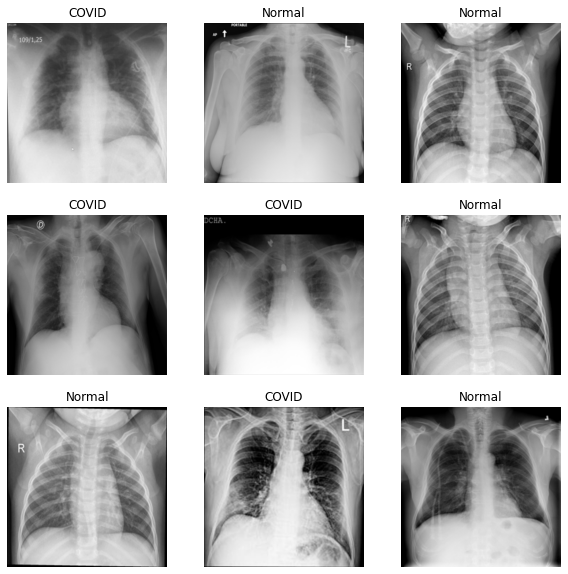

In [ ]:
# Adatped from https://www.tensorflow.org/tutorials/images/classification

plt.figure(figsize=(10,10))
for images, labels in visualise.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(CLASS_NAMES[labels[i]])
    plt.axis('off')
plt.show()

# Pre-processing the data

**Define an ImageDataGenerator object for each of the training and validation subfolders:**

These objects will generate preprocessed batches of images. The pixel values of training images are rescaled from integers to floating-point numbers between 0 and 1. This makes training smoother. Each training image is also augmented with a few different, random transformations. Augmenting training images in this way artifically increases the size of the training set. The hope is that a larger training set will give a 

Validation images are not augmented. This is because a validation set is used for assessing how different models are performing on data not used in training, and for tuning the hyperparameters of a model. Using different validation data for each model would be an invalid evaluation process.

In [ ]:
train_preprocess = ImageDataGenerator(
    rescale=NORMALIZER,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

validation_preprocess = ImageDataGenerator(rescale=NORMALIZER)

**Define a batch generator for each training and validation subfolder**:

These generators use the ImageDataGenerator obejcts defined in the previous cell to  call the flow_from_directory method. This method fetch batches of images, preprocessed and augmented by the ImageDataGenerator objects, and resizes them. Classes are defined according to the names of the class folders in each subfolder.

In [ ]:
train_generator = train_preprocess.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode=IMG_COLOR_MODE,
    class_mode=IMG_CLASS_MODE,
    classes=CLASS_NAMES,
    shuffle=True
)

validation_generator = validation_preprocess.flow_from_directory(
    validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode=IMG_COLOR_MODE,
    class_mode=IMG_CLASS_MODE,
    classes=CLASS_NAMES,  
    shuffle=True
)

Found 8285 images belonging to 2 classes.
Found 2761 images belonging to 2 classes.


**Visualising some properties of the training and validation generators:** 

This is to make sure that the class names have been mapped to the correct indices (Normal: 0, COVID: 1), and that each generator produces batches of the correct data type, and shape.

In [ ]:
images, labels = train_generator.next()
print("Training generator class indices:", train_generator.class_indices)
print("Batch size:", train_generator.batch_size)
print("Batch data type:", train_generator.dtype)
print("Image batch shape:", images.shape)
print("Label batch shape:", labels.shape)

images, labels = validation_generator.next()
print("\nValidation generator class indices:", validation_generator.class_indices)
print("Batch size:", validation_generator.batch_size)
print("Batch data type:", validation_generator.dtype)
print("Image batch shape:", images.shape)
print("Label batch shape:", labels.shape)


Training generator class indices: {'Normal': 0, 'COVID': 1}
Batch size: 32
Batch data type: float32
Image batch shape: (32, 299, 299, 1)
Label batch shape: (32,)

Validation generator class indices: {'Normal': 0, 'COVID': 1}
Batch size: 32
Batch data type: float32
Image batch shape: (32, 299, 299, 1)
Label batch shape: (32,)


**Visualising the effects of data augmentation on some training samples:** 

1. First choose a class folder in the training subfolder and define its files. 
2. Count the files in the class folder.
3. Define an image path as a selection of a random file. 
4. Load the image using the defined image path and define its size. 
5. Convert the image to an array.
6. Reshape the image to have a batch dimension of 1 plus its shape (299, 299, 1)
7. Define a MatPlotLib figure and a loop for plotting each augmented sample. 
8. Fetch a batch of size 1 from the training ImageDataGenerator.
9. Define 2*2 subplot within the main figure.
10. Show each augmented image fetched from the first batch.
11. Set the pixel axis to off to save space.
12. Increment i by 1 with each image shown, and break the loop after 4 images.
13. Show the plotted figure.

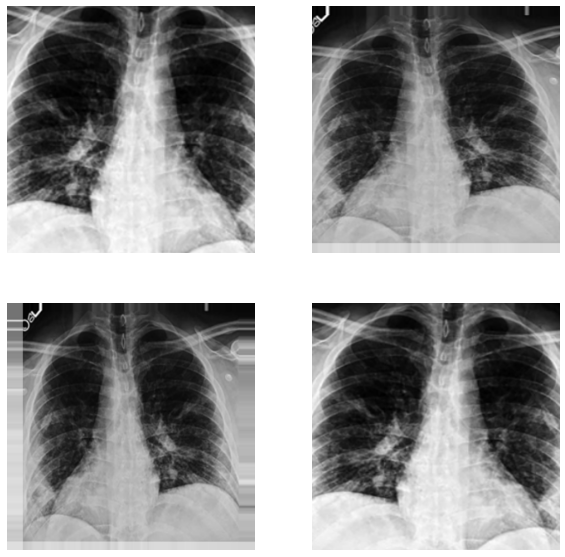

In [ ]:
# Adapted from Chollet, F. (2018). Deep learning with Python. Manning, pg 139-140.

fnames = [os.path.join(train_covid_dir, fname) for fname in os.listdir(train_covid_dir)]
file_count = len(os.listdir(train_covid_dir))
img_path = fnames[random.randrange(0, file_count)]
img = image.load_img(img_path, target_size=(299, 299))
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)

i = 0
plt.figure(figsize=(10, 10))
for batch in train_preprocess.flow(x, batch_size=1):
  plt.subplot(2, 2, i + 1)
  img_plot = plt.imshow(image.array_to_img(batch[0]))
  plt.axis("off")
  i += 1
  if i % 4 == 0:
    break
plt.show()

# Building a model and defining metrics

**Using Keras' sequential model to define a deep convolutional neural network**:

Standard CNN architectures are made up of convolutional layers which use filters to extract features from an input image and output those features to a feature map, one feature map for each filter. This learning of features is automatic, reducing the need for human driven feature engineering. These feature maps are then stacked and reduced in size by Pooling layers which preserve the core structure of a feature map while reducing its complexity. Features learned by deeper layers are made up of features learned by previous layers. The feature-map outputs of the final MaxPooling layer are passed to a densely connected sub-network for classification. The final layer computes a probaility score, with a score greater than 0.5 being classified as positive (COVID). 

In [ ]:
model_name = '1M-6L-ADAM'

model = Sequential(name=model_name)
model.add(InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)))

model.add(Conv2D(32, (4, 4), padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPooling2D(3, 3))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

Model: "1M-6L-ADAM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 299, 299, 32)      544       
_________________________________________________________________
dropout (Dropout)            (None, 299, 299, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 99, 99, 64)        18496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 99, 99, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 49, 49, 64)        3

**Defining the appropriate metrics:**

Other metrics must be used alongside accuracy, as accuracy can be a misleading measure of performance for imbalanced datasets if a model simply predicts the majority class everytime, thereby achieving high accuracy with low skill. Precision and recall are informative metrics for getting a sense of how many type 1 errors (false positives) and type 2 errors (false negatives) a model makes. A precision-recall curve summarises the performance of a model according to its precision and recall scores over a range of different classification thresholds by calculating the area underneath the curve.  

In [ ]:
metrics = [BinaryAccuracy(name='Accuracy'),
           Precision(name='Precision'), 
           Recall(name='Recall')]

**Compiling the model:**

Compiling is done by specifying a loss function (also called a cost function), an optimization algorithm, and a list of metrics, which are already defined.
Cross entropy can be thought of as the distance, between two probability distributions, which in this case are the model's predictions and the expected predictions. This error score is calcluatd for each batch procssed during training and fed into the chosen optimization algorithm, which uses the error as a feedback to adjust the model's weights so that its predictions improve for the next batch.

This is a binary classification problem, as there are only two classes, so binary cross-entropy was chosen for the loss function. Adam was chosen as the optimizer as it is computationally efficient, requires little memory, and is appropriate for problems with many parameters such as this one.

In [ ]:
model.compile(loss=BinaryCrossentropy(),
              optimizer=Adam(learning_rate=0.001),
              metrics=metrics)

# Training the model and plotting results

In [ ]:
models_dir = '/content/drive/MyDrive/models'
model_dir = os.path.join(models_dir, model_name)
if not os.path.isdir(model_dir):
    os.mkdir(model_dir)

**Defining callbacks:**

A directory for saving models is defined and a subdirectory is defined as the joining of a model's name to the models directory. A conditinal tests whether a directory for the given model already exists, if it does not, the directory is created and the model is saved as a H5 file.

In [ ]:
checkpoint_dir = model_dir + '/' + model_name + '.{epoch:02d}-{val_loss:.2f}.h5'

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', mode='min', patience=10, 
                                     restore_best_weights=True),
             
             ModelCheckpoint(filepath=checkpoint_dir, 
                                       monitor='val_loss', 
                                       mode='min', save_best_only=True)]

**Addressing class imbalance through class weighting:**

By passing a python dictionary when fitting a model to the training data, we can instruct the fitting method to pay closer attention to COVID samples, which are underpresented in the overall dataset, by giving the COVID class a higher weight than the Normal class.

In [ ]:
class_weight = {0: 0.677, 1: 1.909}

**Training the model:**

The model is fit by passing the training and validtion generators defined during pre-processing. An epoch is one pass through the entire training set, and the steps per epoch in this case is defined by the size of the tranining set divided by the batch size. The same method is used to calculate the number of validation steps. 

In [ ]:
# Fit model to training data with end-of-epoch validation.
history = model.fit(
    train_generator,
    epochs=10,
    steps_per_epoch= TRAIN_IMG_COUNT / BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps= VALIDATION_IMG_COUNT / BATCH_SIZE, 
    class_weight=class_weight,
    callbacks=callbacks
)

**Plotting training results:**

Results are plotted by enumerating over a defined list of strings which define the keys used to access the history of the models performance for each metric. A seperate figure is created for each metric. The x axis for each figure is the number of epochs and the y axis is the value of the metric at the end of each epoch. Each figure plots the training metric against the validation metric. A model name can be specified for the title of the figure. Finally a background grid is included for each figure and a legend for the training and validation plots.

In [ ]:
for i, metric in enumerate(["Accuracy", "Precision", "Recall", "loss"]):
    epochs = range(1, len(history.history[metric]) + 1)
    plt.figure(figsize=(10,4))
    plt.plot(epochs, history.history[metric], c = '#4682B4', marker = 'D')
    plt.plot(epochs, history.history["val_" + metric], c = '#FF8C00', marker = 'D')
    plt.title(model_name + " {}".format(metric))
    plt.xlabel("epochs")
    plt.ylabel(metric)
    plt.grid()
    plt.legend(["train", "val"])
plt.show()

# Testing a model

**Defining a test generator:**

The test generator is defined in the same way as the training and validation generators and uses the same pre-processing function as the validation generator (normalization of inputs but no data augmentation).

In [ ]:
test_generator = validation_preprocess.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode=IMG_COLOR_MODE,
    class_mode=IMG_CLASS_MODE,
    classes=CLASS_NAMES
)

Get the model's scores for the validation and test data.

In [ ]:
validation = model.evaluate(validation_generator, return_dict=True)
test = model.evaluate(test_generator, return_dict=True)

Define a function for calculating an F2 score. F2  summarises a model's performance as a weighted harmonic mean.

In [ ]:
def F2_score(precision, recall):
  return ((1 + 2**2) * precision * recall) / (2**2 * precision + recall)

Print validation results.

In [ ]:
print('Loss = ' + str(validation['loss']))
print('Precision = ' + str(validation['Precision']))
print('Recall = ' + str(validation['Recall']))
print('F2 = ' + str(F2_score(validation['Precision'], validation['Recall'])))

Print the test results.

In [ ]:
print('Loss = ' + str(test['loss']))
print('Precision = ' + str(test['Precision']))
print('Recall = ' + str(test['Recall']))
print('F2 = ' + str(F2_score(test['Precision'], test['Recall'])))

Loss = 0.21200472116470337
Precision = 0.9073083996772766
Recall = 0.704011082649231
F2 = 0.7370402731946708
